# Assignment 2: Model Building, Tuning, and Evaluation

This notebook covers the end-to-end modeling process for the Customer Churn prediction task.

### Objectives
1.  **Task 1 (Model Building):** Build and compare two baseline Deep Learning models:
    * **Model A:** A Deep Multi-Layer Perceptron (MLP).
    * **Model B:** A 1-D Double-Layered Convolutional Neural Network (CNN), treating tabular features as spatial data.
2.  **Task 2 (Model Tuning):** Use `Keras Tuner` to optimize the hyperparameters (filters, kernel size, dropout) of the CNN model.
3.  **Task 3 (Model Evaluation):** Train the optimal model and evaluate it against the unseen test set using metrics like AUC-ROC, Precision, Recall, and F1-Score.

In [1]:
# Cell 1: Setup and Library Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Keras Tuner for Hyperparameter Optimization
import keras_tuner as kt

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Cell 2: Data Loading and Preparation

# Load datasets generated in Part 1
base_dir = Path.cwd()
train_df = pd.read_csv(base_dir / 'train_final.csv')
test_df = pd.read_csv(base_dir / 'test_final.csv')

# Separate features and target
X_train = train_df.drop('Exited', axis=1)
y_train = train_df['Exited']
X_test = test_df.drop('Exited', axis=1)
y_test = test_df['Exited']

# Reshaping for 1D CNN Input
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Original Feature Shape: {X_train.shape}")
print(f"Reshaped CNN Input:     {X_train_cnn.shape}")

Original Feature Shape: (12740, 14)
Reshaped CNN Input:     (12740, 14, 1)


## Task 1: Model Building

We will train two baseline models to compare their initial performance.
1.  **Deeper MLP:** A dense network with multiple hidden layers and dropout.
2.  **1-D CNN:** A convolutional network that looks for local patterns among features.

In [4]:
# Model A: Deeper MLP

mlp_model = Sequential([
    InputLayer(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Create validation split from training data for monitoring
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training Deeper MLP.")
history_mlp = mlp_model.fit(
    X_train, y_train, 
    validation_split=0.2, 
    epochs=50, 
    batch_size=32, 
    callbacks=[early_stop],
    verbose=0 # Set to 1 to see per-epoch logs
)
print("MLP Training Complete.")

Training Deeper MLP.
MLP Training Complete.


In [ ]:
# Model B: 1-D Double Layered CNN 

cnn_model = Sequential([
    # Input Layer (reshaped for CNN)
    InputLayer(shape=(X_train.shape[1], 1)),
    
    # 1st Convolutional Block
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    
    # 2nd Convolutional Block
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    
    # Flatten and Dense Layers
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

print("Training 1D CNN.")
history_cnn = cnn_model.fit(
    X_train_cnn, y_train, 
    validation_split=0.2, 
    epochs=50, 
    batch_size=32, 
    callbacks=[early_stop],
    verbose=0
)
print("CNN Training Complete.")

Training 1D CNN.
CNN Training Complete.


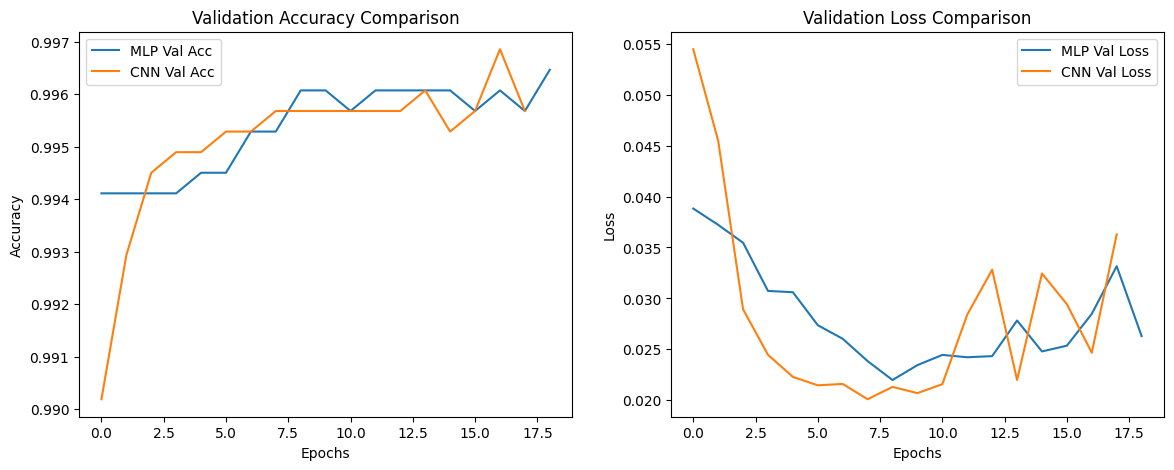

In [6]:
# Compare Model Performance
def plot_comparison(h1, h2, name1="MLP", name2="CNN"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy Plot
    ax[0].plot(h1.history['val_accuracy'], label=f'{name1} Val Acc')
    ax[0].plot(h2.history['val_accuracy'], label=f'{name2} Val Acc')
    ax[0].set_title('Validation Accuracy Comparison')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    
    # Loss Plot
    ax[1].plot(h1.history['val_loss'], label=f'{name1} Val Loss')
    ax[1].plot(h2.history['val_loss'], label=f'{name2} Val Loss')
    ax[1].set_title('Validation Loss Comparison')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.show()

plot_comparison(history_mlp, history_cnn)

## Task 2: Model Tuning with Keras Tuner

We will perform hyperparameter tuning on the **1-D CNN architecture** to maximize validation accuracy. We will search for:
1.  Optimal number of filters in convolution layers.
2.  Optimal kernel size.
3.  Optimal Dense layer units.
4.  Learning Rate.

In [ ]:
# Model A: Hyperparameter Tuning for Deeper MLP

In [ ]:
# Model B: Hyperparameter Tuning for 1-D Double Layered CNN

def build_cnn_hypermodel(hp):
    model = Sequential()
    model.add(InputLayer(shape=(X_train.shape[1], 1)))
    
    # Tune 1st Conv Layer
    hp_filters1 = hp.Int('filters_1', min_value=16, max_value=64, step=16)
    hp_kernel = hp.Choice('kernel_size', values=[2, 3])
    model.add(Conv1D(filters=hp_filters1, kernel_size=hp_kernel, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    
    # Tune 2nd Conv Layer
    hp_filters2 = hp.Int('filters_2', min_value=32, max_value=128, step=32)
    model.add(Conv1D(filters=hp_filters2, kernel_size=hp_kernel, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    
    # Tune Dense Layer
    hp_dense = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_dense, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune Learning Rate
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_lr), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Initialize Tuner
tuner = kt.RandomSearch(
    build_cnn_hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Total combinations to try
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='churn_cnn_tuning',
    overwrite=True
)

# Run Search
print("Starting Hyperparameter Search.")
tuner.search(X_train_cnn, y_train, epochs=20, validation_split=0.2, callbacks=[early_stop], verbose=1)

Trial 10 Complete [00h 02m 33s]
val_accuracy: 0.994113028049469

Best val_accuracy So Far: 0.9952903985977173
Total elapsed time: 00h 23m 20s


In [8]:
# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("--- Optimal Hyperparameters ---")
print(f"Filters Layer 1: {best_hps.get('filters_1')}")
print(f"Filters Layer 2: {best_hps.get('filters_2')}")
print(f"Kernel Size:     {best_hps.get('kernel_size')}")
print(f"Dense Units:     {best_hps.get('dense_units')}")
print(f"Learning Rate:   {best_hps.get('learning_rate')}")

--- Optimal Hyperparameters ---
Filters Layer 1: 64
Filters Layer 2: 96
Kernel Size:     2
Dense Units:     128
Learning Rate:   0.001


## Task 3: Final Model Evaluation

We rebuild the best model and evaluate it on the **unseen test set**.

In [9]:
# Build final model
final_model = tuner.hypermodel.build(best_hps)

# Train on full training data
history_final = final_model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8332 - loss: 0.3450 - val_accuracy: 0.9941 - val_loss: 0.0380
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9977 - loss: 0.0156 - val_accuracy: 0.9941 - val_loss: 0.0310
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9979 - loss: 0.0129 - val_accuracy: 0.9941 - val_loss: 0.0333
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9984 - loss: 0.0110 - val_accuracy: 0.9941 - val_loss: 0.0364
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9982 - loss: 0.0092 - val_accuracy: 0.9949 - val_loss: 0.0295
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9980 - loss: 0.0101 - val_accuracy: 0.9941 - val_loss: 0.0340
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9977 - loss: 0.0107 - val_accuracy: 0.9949 - val_loss: 0.0315
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9984 - loss: 0.0092 - val_accuracy: 0.


--- Evaluation on Test Set ---
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0168 
Test Loss: 0.0255
Test Accuracy: 0.9970
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       0.99      0.99      0.99       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



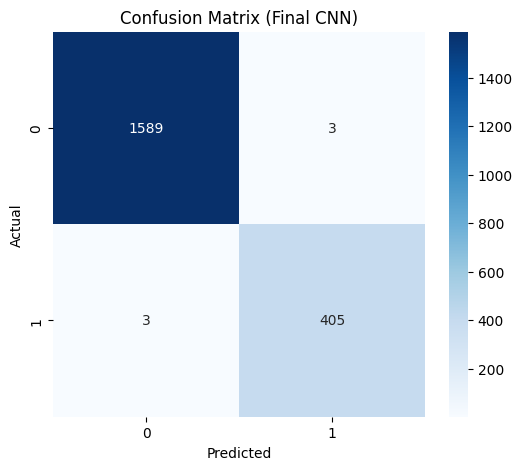

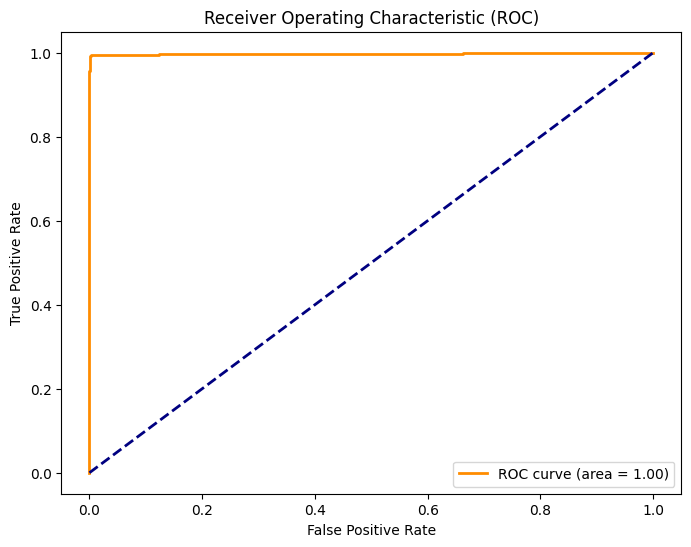

In [10]:
# Evaluate on Test Data
print("\n--- Evaluation on Test Set ---")
loss, accuracy = final_model.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
y_pred_prob = final_model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Final CNN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()